# Granular Demand Forecast

This notebook walks through each step to create more granular, product-level forecasts using FB's prophet library. </br>
</br>
General workflow is as follows:
1. Create top line forecast to use as regressor later on
2. Create size-specific forecasts
3. ...


In [1]:
import os
import yaml
import datetime
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import psycopg2
import pandas as pd
import numpy as np
import urllib.request
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from sqlalchemy import text
from sqlalchemy import create_engine

In [2]:
# setting WD
os.chdir('/Users/Daniel.Kwon/projects')

In [3]:
# database connection info
with open("./redshift_credentials.yml", 'r') as stream:
    try:
        rs_cred = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
engine_url = "postgresql://{user_name}:{pw}@{host}:{port}/{db_name}".format(user_name = rs_cred['default']['user'],
                                                                            pw        = urllib.parse.quote_plus(rs_cred['default']['password']),
                                                                            host      = rs_cred['default']['host'],
                                                                            port      = rs_cred['default']['port'],
                                                                            db_name   = rs_cred['default']['dbname']
                                                                           )
engine = create_engine(engine_url)

In [10]:
# query
query = open('./granular-demand-forecast/sql/rug_sales.sql', 'r')
query_text = text(query.read())
df_sales = pd.read_sql_query(query_text, engine)

# get ad spend
df_spend = pd.read_csv('./data/granular-demand-forecast/ad_spend.csv')

# get marketing events
df_event = pd.read_csv('./data/granular-demand-forecast/marketing_events.csv')

# log transform regressor
df_spend['log_total_weekly_spend'] = np.log(df_spend['total_weekly_spend']+1)

# log transform y
df_sales['log_total_rugs_sold'] = np.log(df_sales['total_rugs_sold']+1)

# merge df
df_spend['week_begin_date']=pd.to_datetime(df_spend['week_begin_date'])
df_event['week_begin_date']=pd.to_datetime(df_event['week_begin_date'])
df_sales['week_begin_date']=pd.to_datetime(df_sales['week_begin_date'])
df_sales = df_sales.merge(df_spend, how='inner', on='week_begin_date')
df_sales = df_sales.merge(df_event, how='inner', on='week_begin_date')

## Creating Top Line Forecast

Forecast total number of rugs for use as inputs for other forecasts

In [11]:
df = df_sales[['week_begin_date',
               'total_rugs_sold',
               'log_total_rugs_sold',
               'total_weekly_spend',
               'log_total_weekly_spend',
               'google_and_bing_weekly_spend',
               'sale',
               'launch',
               'bfcm',
               'anniversary',
               'spring',
               'nynh',
               'memorial_day',
               'email',
               'test'
              ]].rename(columns={'week_begin_date':'ds',
                                 'total_rugs_sold':'y'})

In [12]:
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.01)

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_weekly_spend',mode='multiplicative')
m.add_regressor('sale')
m.add_regressor('launch')
m.add_regressor('bfcm')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

# cross validate
df_cv = cross_validation(m, initial='110 W', period='1 W', horizon = '12 W')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 14 forecasts with cutoffs between 2021-02-15 00:00:00 and 2021-05-17 00:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,4.049894e+08,20124.347600,19110.141380,0.490699,0.488328,0.382866,0.071429
1,21 days,4.612769e+08,21477.358418,20373.844966,0.526299,0.528737,0.404765,0.008929
2,28 days,4.518045e+08,21255.693108,20255.658854,0.522078,0.484087,0.402781,0.000000
3,35 days,5.079560e+08,22537.880105,21616.699773,0.570897,0.580712,0.434998,0.000000
4,42 days,5.422563e+08,23286.397728,22175.991472,0.593089,0.563876,0.445473,0.062500


In [13]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_spend, 
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_event,
                      left_on='ds', right_on='week_begin_date')
forecast = m.predict(future)

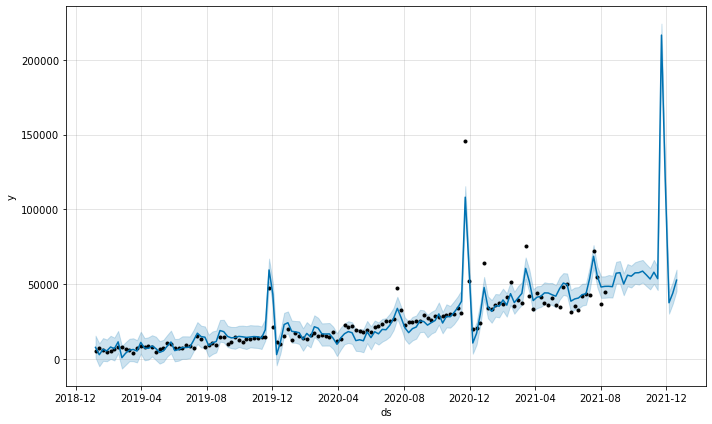

In [14]:
fig = m.plot(forecast)

In [15]:
df_topline = forecast[['ds', 'yhat']]
df_topline = df_topline.merge(df[['ds','y']], how='left', on='ds')
df_topline['merged_total_rugs'] = df_topline.y.combine_first(df_topline.yhat)
df_topline = df_topline.rename(columns={'yhat':'forecasted_total_rugs',
                                        'y':'actual_total_rugs'})

## Indoor / Outdoor Chenille (to be used as inputs for granular forecasts)

In [16]:
# function + texture
query = open('./granular-demand-forecast/sql/rug_sales_function-texture.sql', 'r')
query_text = text(query.read())
df_sales_FT = pd.read_sql_query(query_text, engine)
df_sales_FT['week_begin_date']=pd.to_datetime(df_sales_FT['week_begin_date'])
df_sales_FT = df_sales_FT.merge(df_event, how='inner', on='week_begin_date')

### Indoor Chenille - % of Total

In [17]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Indoor') &
                     (df_sales_FT['texture']=='Chenille')].rename(columns={'week_begin_date': 'ds',
                                                                           'percent_of_total': 'y'})
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False)

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

# CV resulting model
df_cv = cross_validation(m, initial='110 W', period='1 W', horizon = '12 W')

# forecast future values
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event,
                      left_on='ds',
                      right_on='week_begin_date')
future = future.merge(df_topline, on='ds').rename(columns={'merged_total_rugs': 'total_rugs_sold'})
forecast = m.predict(future)

INFO:prophet:Making 14 forecasts with cutoffs between 2021-02-15 00:00:00 and 2021-05-17 00:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

In [18]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,0.000470,0.021691,0.017846,0.020424,0.012039,0.020226,0.446429
1,21 days,0.000352,0.018748,0.015908,0.018177,0.013491,0.018056,0.428571
2,28 days,0.000338,0.018373,0.015371,0.017579,0.012787,0.017508,0.491071
3,35 days,0.000420,0.020494,0.016625,0.019049,0.013817,0.018984,0.500000
4,42 days,0.000459,0.021421,0.017235,0.019889,0.024815,0.019770,0.500000


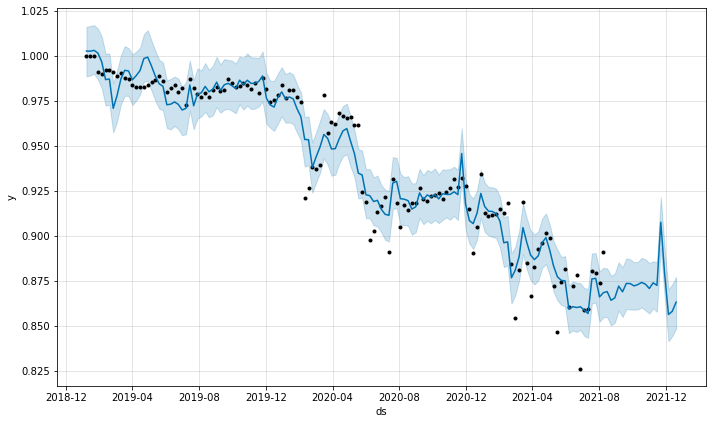

In [19]:
fig = m.plot(forecast)

In [20]:
df_IndoorChenille = forecast[['ds', 'yhat']]
df_IndoorChenille = df_IndoorChenille.merge(df[['ds','y']], how='left', on='ds')
df_IndoorChenille['y_merged'] = df_IndoorChenille.y.combine_first(df_IndoorChenille.yhat)
df_IndoorChenille = df_IndoorChenille.rename(columns={'yhat':'forecast',
                                                      'y':'actual',
                                                      'y_merged':'merged'})
df_IndoorChenille['function'] = 'Indoor'
df_IndoorChenille['texture'] = 'Chenille'

### Outdoor Chenille - % of Total

In [21]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Outdoor') &
                     (df_sales_FT['texture']=='Chenille')].rename(columns={'week_begin_date':'ds',
                                                                           'percent_of_total':'y'})
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.06,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('outdoor')

# train model
m.fit(df)

# CV resulting model
df_cv = cross_validation(m, initial='52 W', period='1 W', horizon = '4 W')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 8 forecasts with cutoffs between 2021-05-24 00:00:00 and 2021-07-12 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000186,0.013627,0.012750,0.312742,0.321236,0.285646,0.125
1,14 days,0.000175,0.013240,0.012002,0.330821,0.361324,0.276849,0.125
2,21 days,0.000175,0.013225,0.012378,0.361442,0.369031,0.301920,0.125
3,28 days,0.000152,0.012338,0.011635,0.373204,0.371858,0.311027,0.125


In [22]:
# forecast future values
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event,
                      left_on='ds',
                      right_on='week_begin_date')
future = future.merge(df_topline, on='ds').rename(columns={'merged_total_rugs': 'total_rugs_sold'})
forecast = m.predict(future)

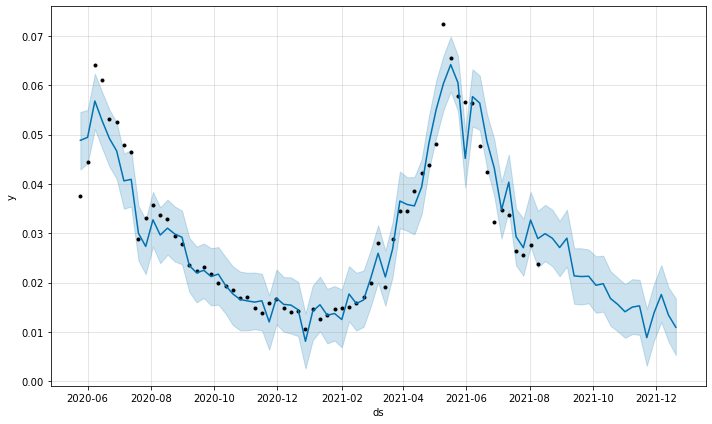

In [23]:
fig = m.plot(forecast)

In [24]:
df_OutdoorChenille = forecast[['ds', 'yhat']]
df_OutdoorChenille = df_OutdoorChenille.merge(df[['ds','y']], how='left', on='ds')
df_OutdoorChenille['y_merged'] = df_OutdoorChenille.y.combine_first(df_OutdoorChenille.yhat)
df_OutdoorChenille = df_OutdoorChenille.rename(columns={'yhat':'forecast',
                                                        'y':'actual',
                                                        'y_merged':'merged'})
df_OutdoorChenille['function'] = 'Outdoor'
df_OutdoorChenille['texture'] = 'Chenille'

In [25]:
df_Chenille = pd.concat([df_IndoorChenille, df_OutdoorChenille])

In [26]:
df_Chenille.head()

,ds,forecast,actual,merged,function,texture
0,2019-01-07,1.002668,1.000000,1.000000,Indoor,Chenille
1,2019-01-14,1.002558,1.000000,1.000000,Indoor,Chenille
2,2019-01-21,1.003046,1.000000,1.000000,Indoor,Chenille
3,2019-01-28,1.001491,0.991226,0.991226,Indoor,Chenille
4,2019-02-04,0.996618,0.989826,0.989826,Indoor,Chenille


## Loop Through Sizes

In [28]:
# function + texture + size
query = open('./granular-demand-forecast/sql/rug_sales_function-texture-size.sql', 'r')
query_text = text(query.read())
df_sales_FTS = pd.read_sql_query(query_text, engine)
df_sales_FTS['week_begin_date']=pd.to_datetime(df_sales_FTS['week_begin_date'])
df_sales_FTS = df_sales_FTS.merge(df_event, how='inner', on='week_begin_date')

INFO:prophet:n_changepoints greater than number of observations. Using 7.


fitting model for Indoor 2x3 Chenille
-------------------------
fitting model for Indoor 2.5x7 Chenille
-------------------------
fitting model for Indoor 2.5x10 Chenille
-------------------------
fitting model for Indoor 3x5 Chenille
-------------------------
fitting model for Indoor 5x7 Chenille
-------------------------
fitting model for Indoor 6x9 Chenille
-------------------------
fitting model for Indoor 8x10 Chenille
-------------------------
fitting model for Indoor 9x12 Chenille
-------------------------
fitting model for Indoor 6" Round Chenille
-------------------------
fitting model for Indoor 8" Round Chenille
-------------------------
fitting model for Outdoor 2.5x7 Chenille
-------------------------
fitting model for Outdoor 2.5x10 Chenille
-------------------------
fitting model for Outdoor 3x5 Chenille
-------------------------
fitting model for Outdoor 5x7 Chenille
-------------------------
fitting model for Outdoor 6x9 Chenille
-------------------------
fitting model

/Users/Daniel.Kwon/opt/anaconda3/lib/python3.8/site-packages/prophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:prophet:n_changepoints greater than number of observations. Using 9.


-------------------------
fitting model for Outdoor 2.5x7 Jute


INFO:prophet:n_changepoints greater than number of observations. Using 8.


-------------------------
fitting model for Outdoor 2.5x10 Jute


INFO:prophet:n_changepoints greater than number of observations. Using 8.


-------------------------
fitting model for Outdoor 3x5 Jute


INFO:prophet:n_changepoints greater than number of observations. Using 8.


-------------------------
fitting model for Outdoor 5x7 Jute


INFO:prophet:n_changepoints greater than number of observations. Using 11.


-------------------------
fitting model for Doormat 2x3 Bristle
-------------------------


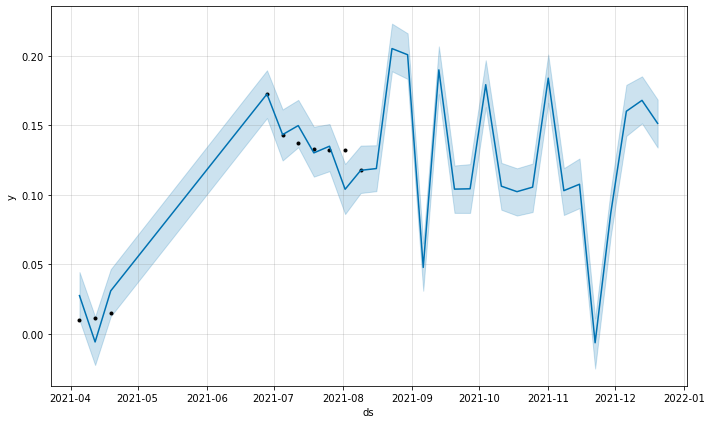

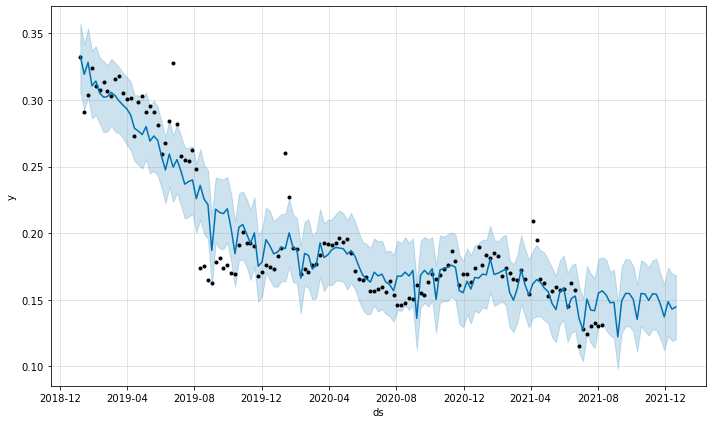

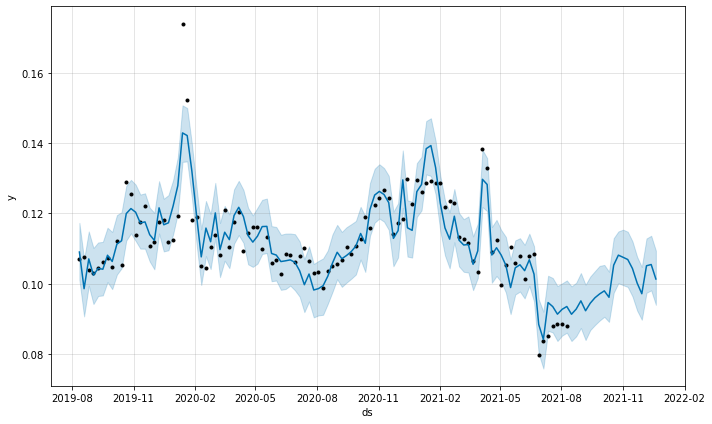

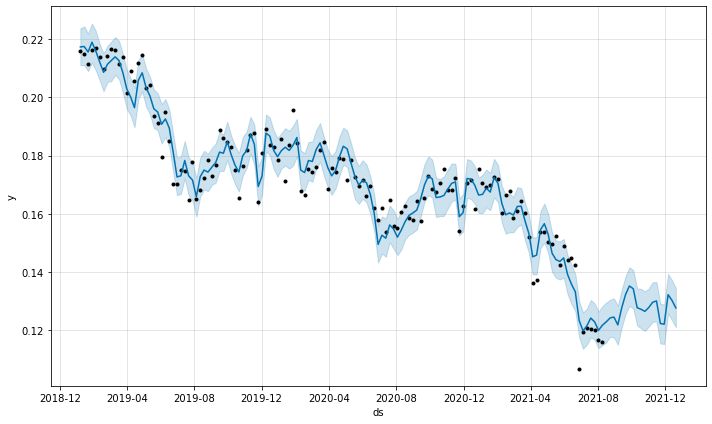

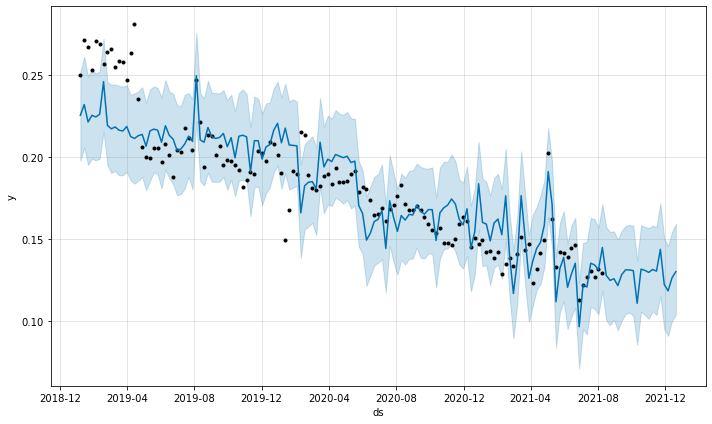

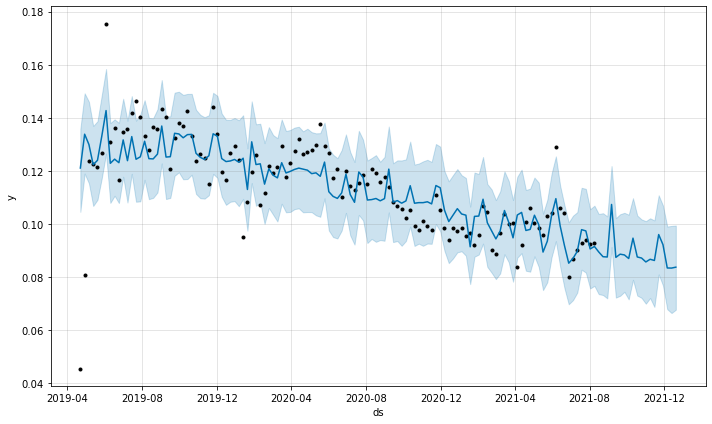

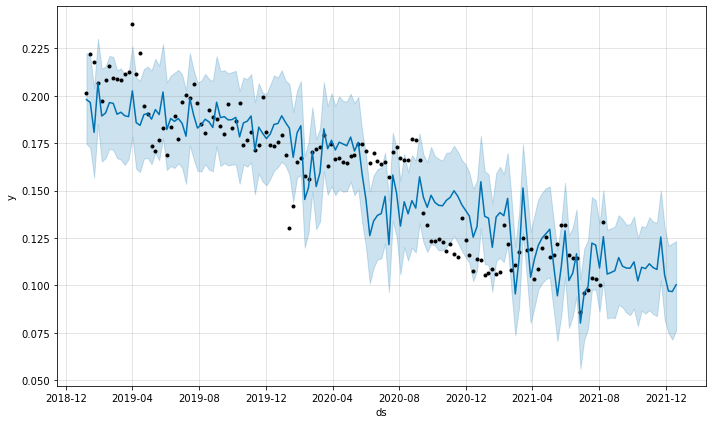

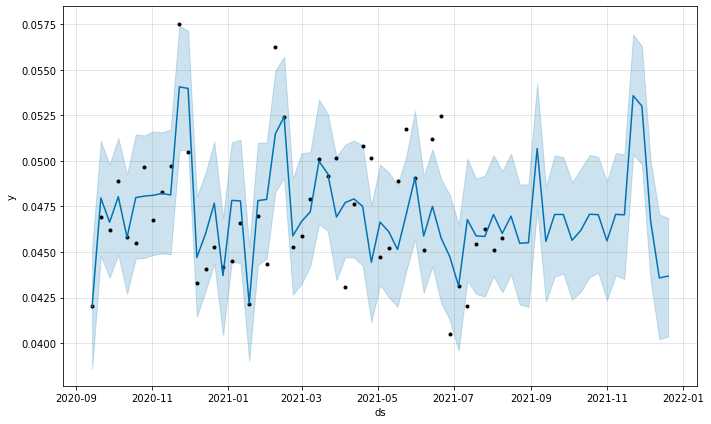

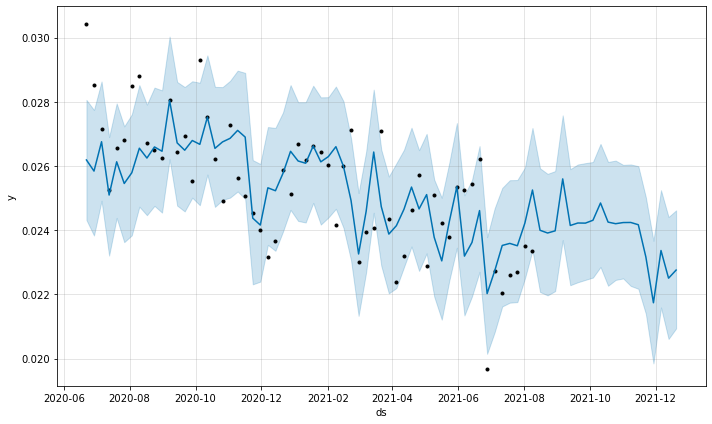

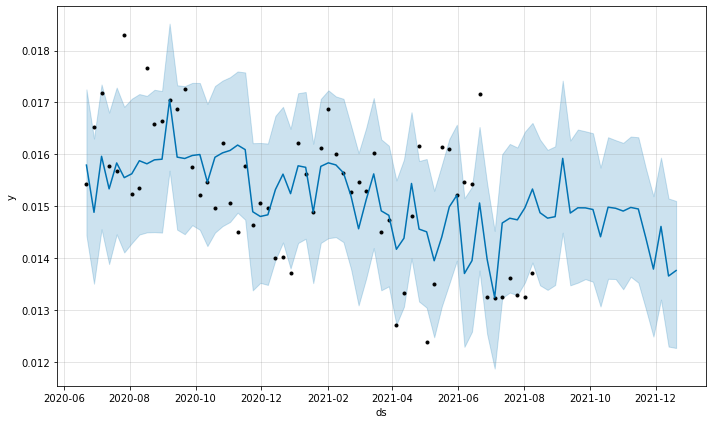

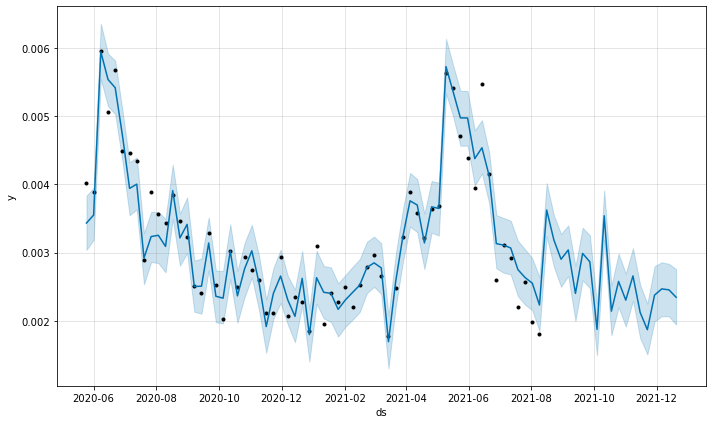

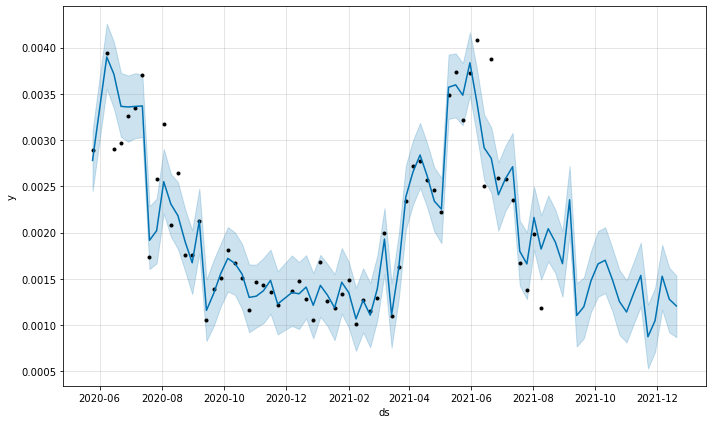

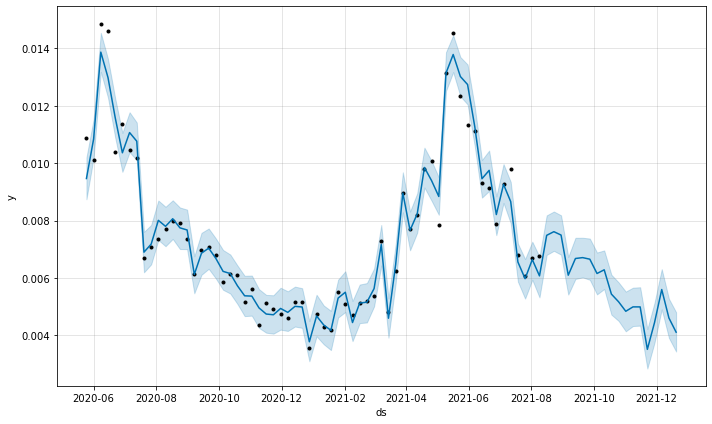

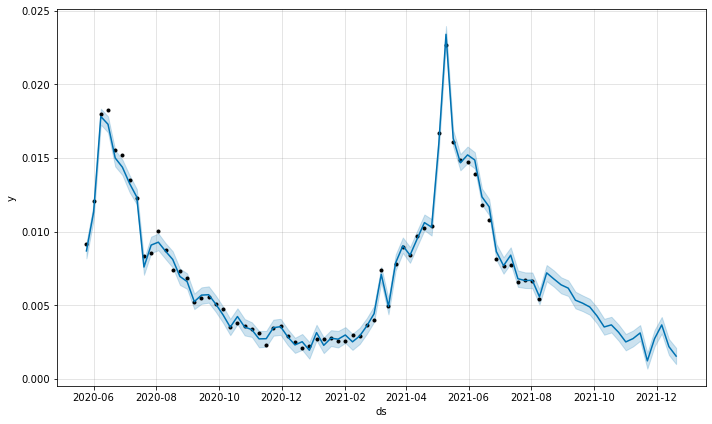

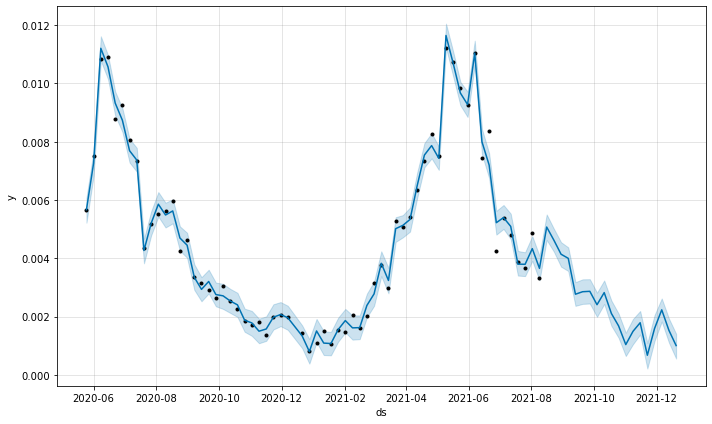

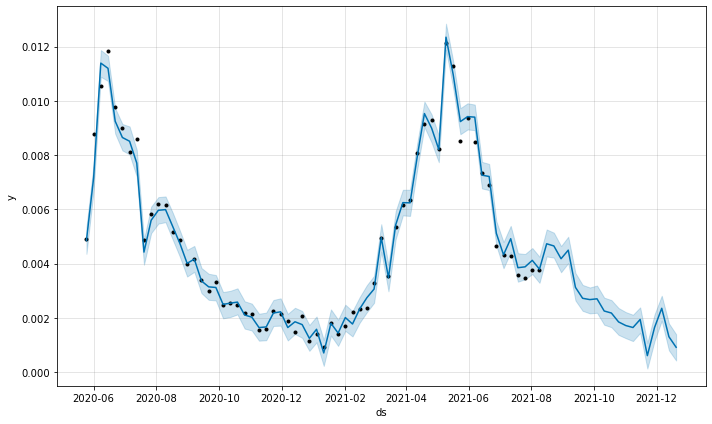

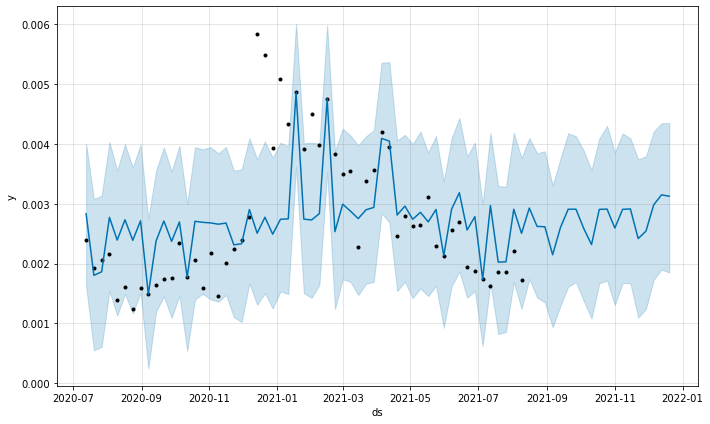

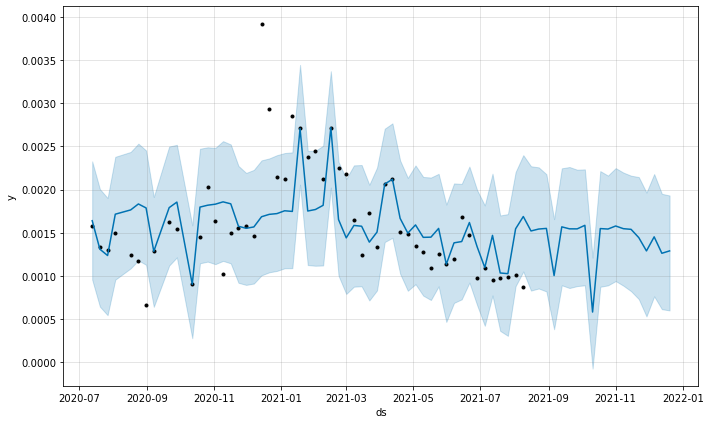

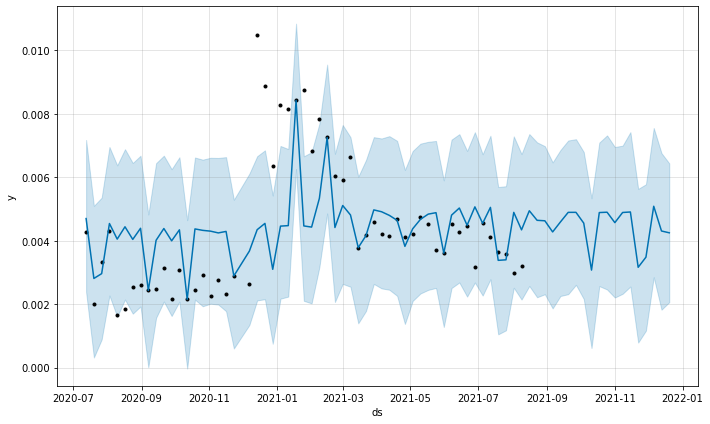

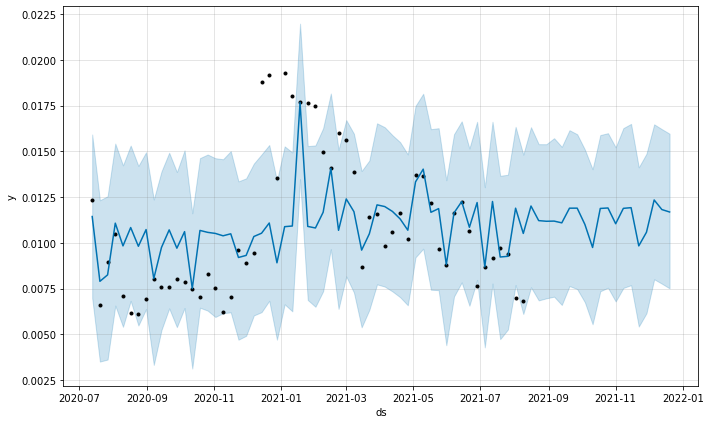

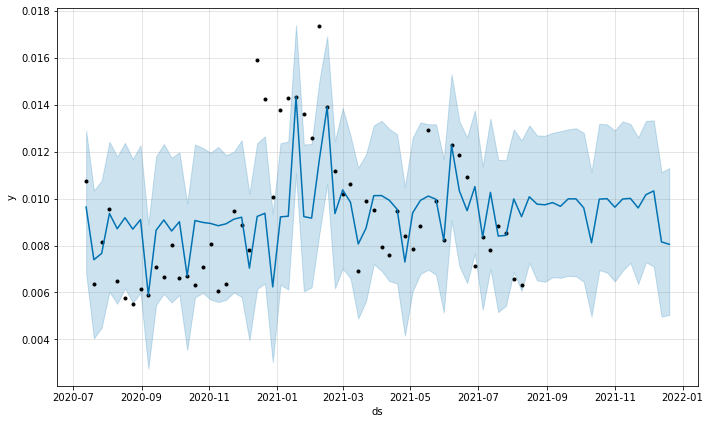

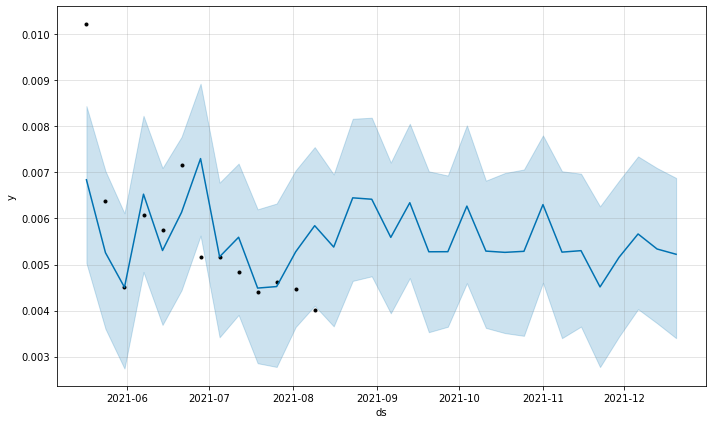

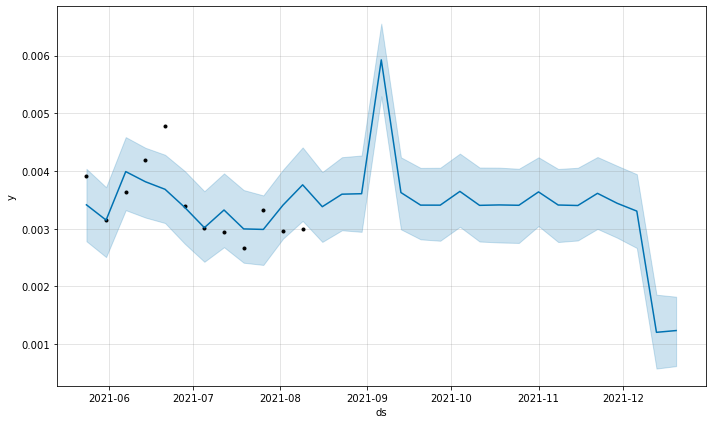

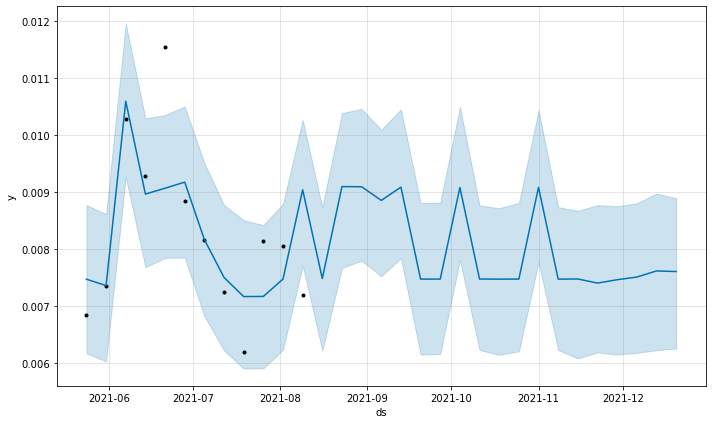

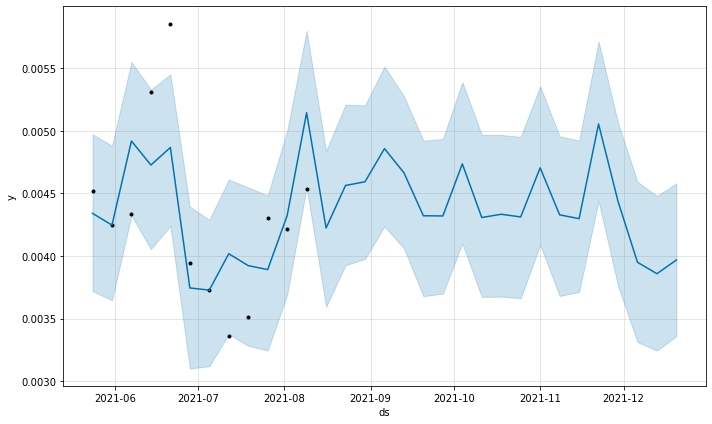

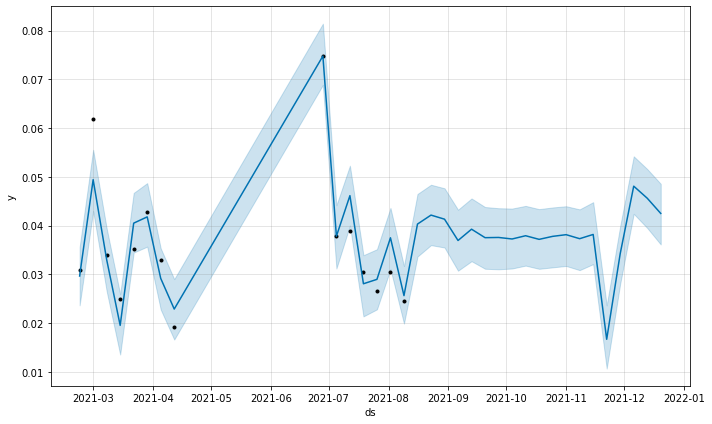

In [29]:
model_parameters = {
    'Indoor 2x3 Chenille'       :['2x3','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 2.5x7 Chenille'     :['2.5x7','Indoor','Chenille','Indoor','Chenille',False,0.05,'linear'],
    'Indoor 2.5x10 Chenille'    :['2.5x10','Indoor','Chenille','Indoor','Chenille',True,0.05,'linear'],
    'Indoor 3x5 Chenille'       :['3x5','Indoor','Chenille','Indoor','Chenille',True,0.05,'linear'],
    'Indoor 5x7 Chenille'       :['5x7','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 6x9 Chenille'       :['6x9','Indoor','Chenille','Indoor','Chenille',False,0.05,'linear'],
    'Indoor 8x10 Chenille'      :['8x10','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 9x12 Chenille'      :['9x12','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 6" Round Chenille'  :['6" Round','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 8" Round Chenille'  :['8" Round','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 2.5x7 Chenille'    :['2.5x7','Outdoor','Chenille','Outdoor','Chenille',True,0.06,'flat'],
    'Outdoor 2.5x10 Chenille'   :['2.5x10','Outdoor','Chenille','Outdoor','Chenille',True,0.06,'flat'],
    'Outdoor 3x5 Chenille'      :['3x5','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Outdoor 5x7 Chenille'      :['5x7','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Outdoor 6x9 Chenille'      :['6x9','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Outdoor 8x10 Chenille'     :['8x10','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Indoor 2.5x7 Plush'        :['2.5x7','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Indoor 2.5x10 Plush'       :['2.5x10','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Indoor 3x5 Plush'          :['3x5','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Indoor 5x7 Plush'          :['5x7','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Indoor 6x9 Plush'          :['6x9','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Outdoor 2.5x7 Jute'        :['2.5x7','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 2.5x10 Jute'       :['2.5x10','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 3x5 Jute'          :['3x5','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 5x7 Jute'          :['5x7','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Doormat 2x3 Bristle'       :['2x3','Doormat','Bristle','Indoor','Chenille',False,0.05,'flat']
}

df_forecasts = pd.DataFrame(columns = ['ds','yhat','y','y_merged','size'])

for i in model_parameters.items():
    print("fitting model for {}".format(i[0]))
    df = df_sales_FTS.loc[(df_sales_FTS['function']==i[1][1]) &
                          (df_sales_FTS['texture']==i[1][2]) &
                          (df_sales_FTS['size']==i[1][0])].rename(columns={'week_begin_date':'ds',
                                                                        'percent_of_total':'y'})
    df_input = df_Chenille.loc[(df_Chenille['function']==i[1][3]) &
                               (df_Chenille['texture']==i[1][4]),
                               ['ds','merged']].rename(columns={'merged':'percent_of_total_input'})
    df = df.merge(df_input, how='inner', on='ds')
    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][5],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][6],
                growth=i[1][7])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    m.add_regressor('percent_of_total_input')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    m.add_regressor('email')
    m.add_regressor(i[1][0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_input, on='ds')
    # create forecast
    forecast = m.predict(future)
    fig = m.plot(forecast)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[1][0]
    df_outputs['function'] = i[1][1]
    df_outputs['texture'] = i[1][2]
    df_forecasts = df_forecasts.append(df_outputs)
    print("-"*25)

INFO:prophet:n_changepoints greater than number of observations. Using 5.


fitting model for Indoor 2x3 Plush


INFO:prophet:n_changepoints greater than number of observations. Using 4.


-------------------------
fitting model for Pad Only 2x3
-------------------------
fitting model for Pad Only 2.5x7
-------------------------
fitting model for Pad Only 2.5x10
-------------------------
fitting model for Pad Only 3x5
-------------------------
fitting model for Pad Only 5x7
-------------------------
fitting model for Pad Only 6x9
-------------------------
fitting model for Pad Only 8x10
-------------------------
fitting model for Pad Only 9x12


INFO:prophet:n_changepoints greater than number of observations. Using 5.


-------------------------
fitting model for Pad Only 6" Round


INFO:prophet:n_changepoints greater than number of observations. Using 1.


-------------------------
fitting model for Pad Only 8" Round
-------------------------


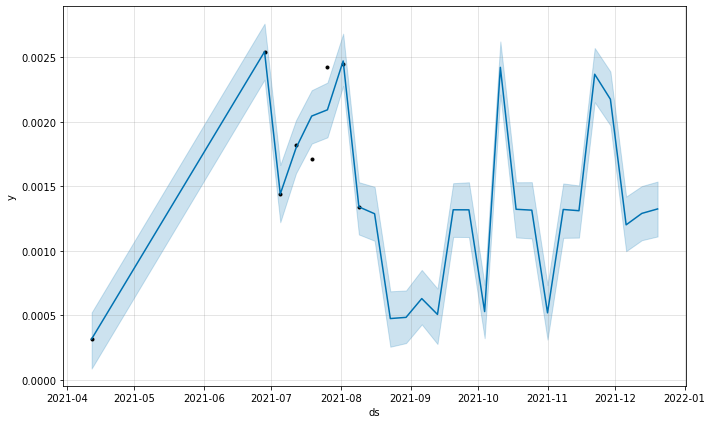

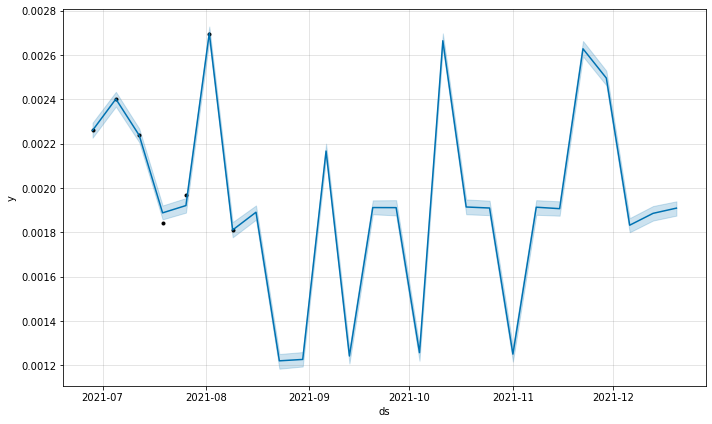

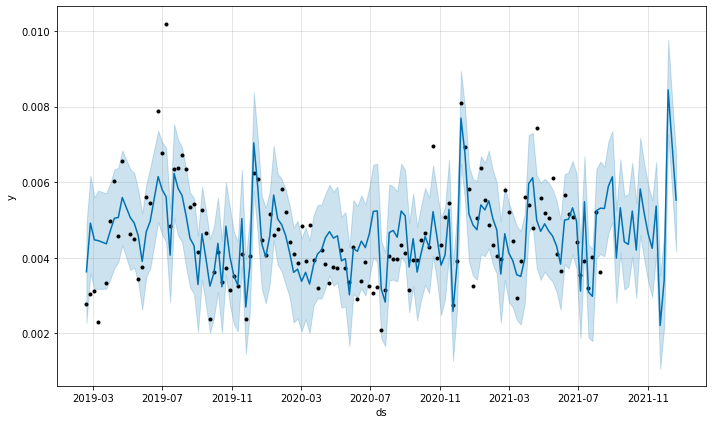

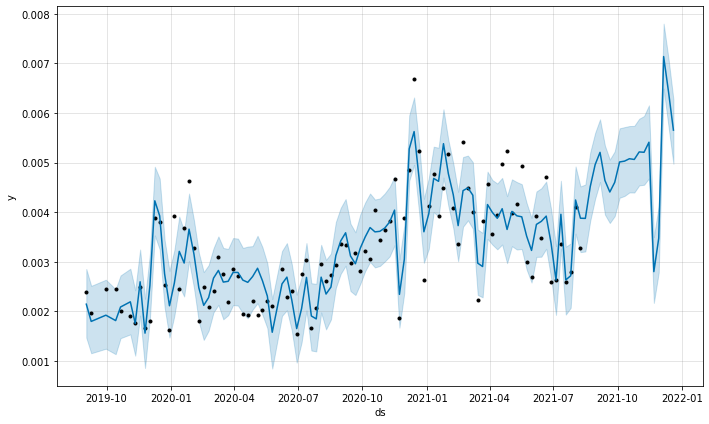

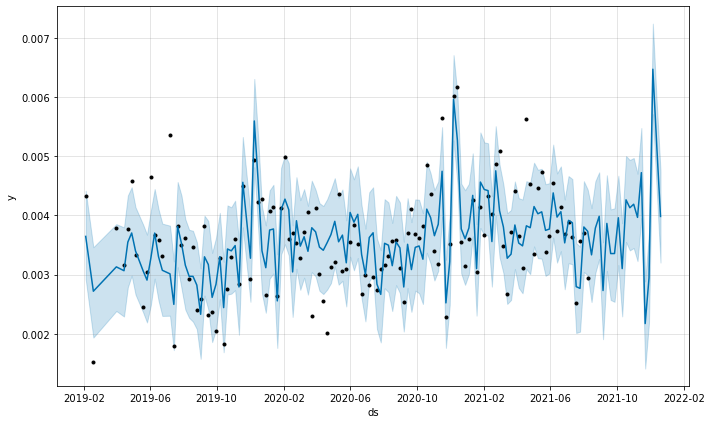

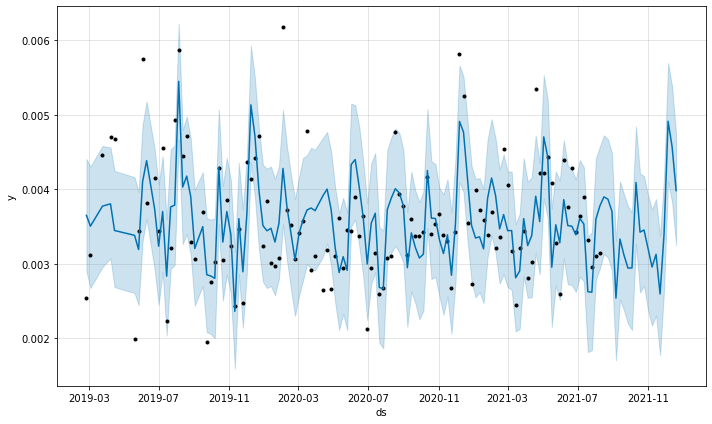

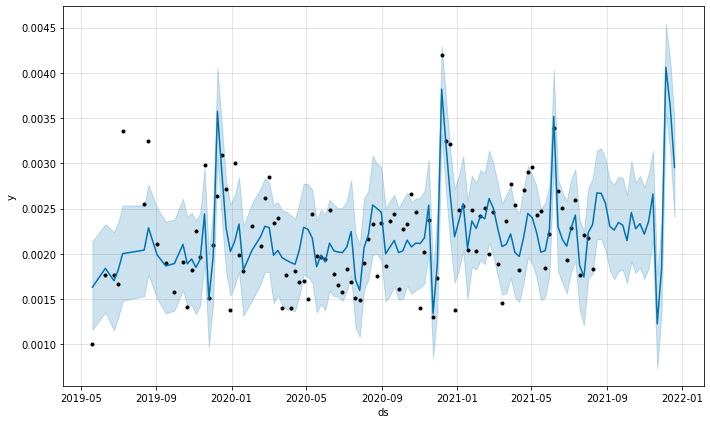

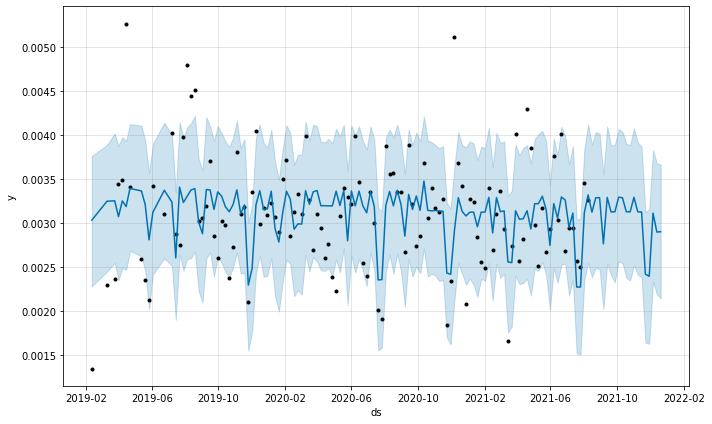

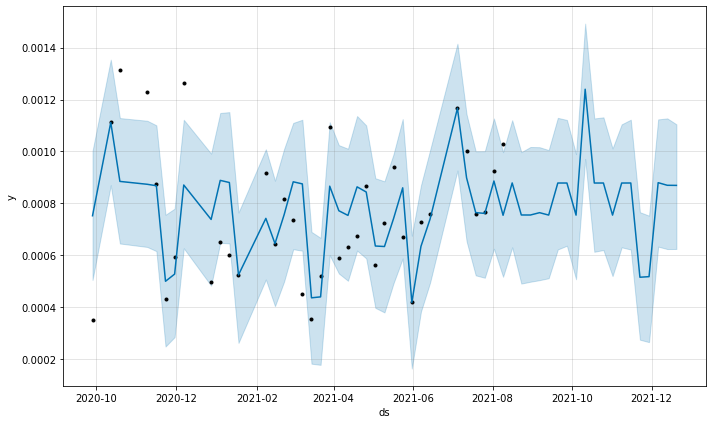

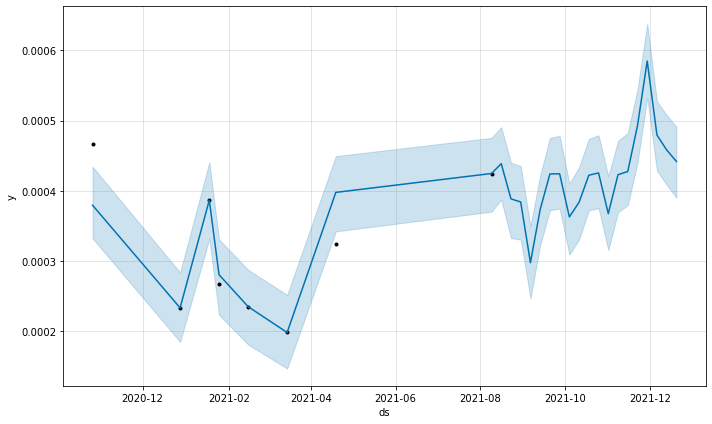

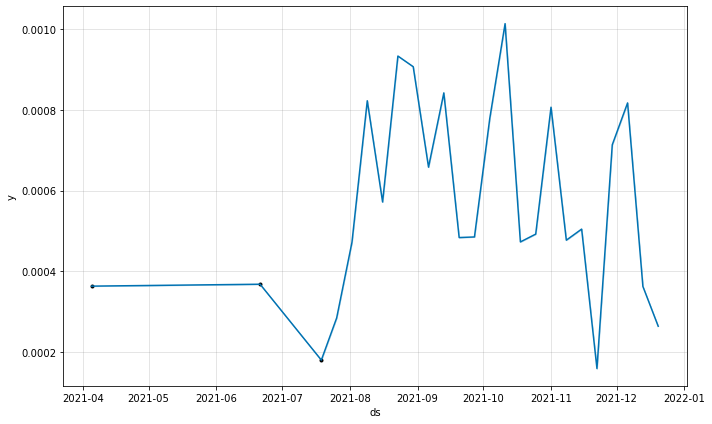

In [30]:
model_parameters = {
    'Indoor 2x3 Plush'  :['2x3','Indoor','Plush','3x5','Indoor','Plush',False,0.9,'flat'],
    'Pad Only 2x3'      :['2x3','NUL','Rubber pad','3x5','Indoor','Plush',False,0.9,'flat'],
    'Pad Only 2.5x7'    :['2.5x7','NUL','Rubber pad','2.5x7','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 2.5x10'   :['2.5x10','NUL','Rubber pad','2.5x10','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 3x5'      :['3x5','NUL','Rubber pad','3x5','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 5x7'      :['5x7','NUL','Rubber pad','5x7','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 6x9'      :['6x9','NUL','Rubber pad','6x9','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 8x10'     :['8x10','NUL','Rubber pad','8x10','Indoor','Chenille',False,0.05,'flat'],
    'Pad Only 9x12'     :['9x12','NUL','Rubber pad','9x12','Indoor','Chenille',False,0.05,'flat'],
    'Pad Only 6" Round' :['6" Round','NUL','Rubber pad','6" Round','Indoor','Chenille',False,0.01,'flat'],
    'Pad Only 8" Round' :['8" Round','NUL','Rubber pad','5x7','Indoor','Chenille',False,0.01,'flat']
}

for i in model_parameters.items():
    print("fitting model for {}".format(i[0]))
    df       = df_sales_FTS.loc[(df_sales_FTS['function']==i[1][1]) &
                                (df_sales_FTS['texture']==i[1][2]) &
                                (df_sales_FTS['size']==i[1][0])].rename(columns={'week_begin_date':'ds',
                                                                                 'percent_of_total':'y'})
    df_input = df_forecasts.loc[(df_forecasts['function']==i[1][4]) &
                                (df_forecasts['texture']==i[1][5]) &
                                (df_forecasts['size']==i[1][3]),
                                ['ds','y_merged']].rename(columns={'y_merged':'input_ts'})
    df = df.merge(df_input, how='inner', on='ds')

    df['floor'] = 0.0001

    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][6],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][7],
                growth=i[1][8])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    m.add_regressor('email')
    m.add_regressor('input_ts')
    m.add_regressor(i[1][0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_input, on='ds')
    future['floor'] = 0.0001
    # create forecast
    forecast = m.predict(future)
    fig = m.plot(forecast)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[1][0]
    df_outputs['function'] = i[1][1]
    df_outputs['texture'] = i[1][2]
    df_forecasts = df_forecasts.append(df_outputs)
    print("-"*25)

## Make adjustments and push to DW

In [41]:
df_forecasts.head()

,ds,yhat,y,y_merged,size,function,texture
0,2021-04-05,0.027643,0.010285,0.010285,2x3,Indoor,Chenille
1,2021-04-12,-0.005675,0.011679,0.011679,2x3,Indoor,Chenille
2,2021-04-19,0.031055,0.015167,0.015167,2x3,Indoor,Chenille
3,2021-06-28,0.172519,0.172509,0.172509,2x3,Indoor,Chenille
4,2021-07-05,0.143358,0.143357,0.143357,2x3,Indoor,Chenille


In [31]:
avg_forecast = df_forecasts.loc[(df_forecasts['size']=='8" Round') &
                       (df_forecasts['function']=='NUL') &
                       (df_forecasts['texture']=='Rubber pad') &
                       (df_forecasts['y'].notnull()),
                       ['y']].copy().apply(np.average, axis=0)

df_forecasts['yhat'] = np.where((df_forecasts['size'] == '8" Round') &
                                (df_forecasts['function'] == 'NUL') &
                                (df_forecasts['texture'] == 'Rubber pad'), avg_forecast.values,df_forecasts.yhat.values)

In [33]:
today = date.today()

In [34]:
(today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")

'2021-08-16'

In [35]:
forecast_begin_date = (today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")
df_gdf =df_forecasts.loc[(df_forecasts['ds'] >= forecast_begin_date),
                         ['ds',
                          'y_merged',
                          'size',
                          'function',
                          'texture'
                         ]].rename(columns={'ds':'horizon_date',
                                            'y_merged':'forecasted_percent_of_total'})
df_gdf['created_date'] = today.strftime("%Y-%m-%d")
df_gdf.sort_values(by=['function','texture','size','horizon_date','created_date'],inplace=True)

In [39]:
df_gdf.loc[df_gdf['created_date']== "2021-08-16"]

,horizon_date,forecasted_percent_of_total,size,function,texture,created_date
15,2021-08-16,0.040315,2x3,Doormat,Bristle,2021-08-16
16,2021-08-23,0.042156,2x3,Doormat,Bristle,2021-08-16
17,2021-08-30,0.041319,2x3,Doormat,Bristle,2021-08-16
18,2021-09-06,0.036945,2x3,Doormat,Bristle,2021-08-16
19,2021-09-13,0.039264,2x3,Doormat,Bristle,2021-08-16
...,...,...,...,...,...,...
26,2021-11-22,0.005054,5x7,Outdoor,Jute,2021-08-16
27,2021-11-29,0.004436,5x7,Outdoor,Jute,2021-08-16
28,2021-12-06,0.003950,5x7,Outdoor,Jute,2021-08-16
29,2021-12-13,0.003858,5x7,Outdoor,Jute,2021-08-16


In [40]:
df_gdf.to_sql('gdf_outputs_test', engine, schema = 'temp_entities', index=False, if_exists='append')

In [42]:
df_gdf.head()

,horizon_date,forecasted_percent_of_total,size,function,texture,created_date
15,2021-08-16,0.040315,2x3,Doormat,Bristle,2021-08-16
16,2021-08-23,0.042156,2x3,Doormat,Bristle,2021-08-16
17,2021-08-30,0.041319,2x3,Doormat,Bristle,2021-08-16
18,2021-09-06,0.036945,2x3,Doormat,Bristle,2021-08-16
19,2021-09-13,0.039264,2x3,Doormat,Bristle,2021-08-16
